# Read Data from the Doppler Lidar

In [45]:
import glob
import utils
import xarray as xr
import pandas as pd
import numpy as np
import cmweather
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import datetime
from scipy.signal import convolve2d
import scipy
import os
import act
#import sage_data_client
import cartopy.crs as ccrs

## Compile a list of data files

In [20]:
files = sorted(glob.glob('/Users/rjackson/dl_cal_data/*.hpl'))
#files = ['/Users/rjackson/instrument-cookbooks/notebooks/doppler-lidar/User1_240_20240127_203719.hpl']

In [20]:
def convert_to_hours_minutes_seconds(decimal_hour, initial_time):
    delta = timedelta(hours=decimal_hour)
    return datetime(initial_time.year, initial_time.month, initial_time.day) + delta

def read_as_netcdf(file, lat, lon, alt, transition_threshold_azi=0.01,
                  transition_threshold_el=0.005, round_azi=1, round_el=1):
    field_dict = utils.hpl2dict(file)
    initial_time = pd.to_datetime(field_dict['start_time'])

    time = pd.to_datetime([convert_to_hours_minutes_seconds(x, initial_time) for x in field_dict['decimal_time']])

    ds = xr.Dataset(coords={'range':field_dict['center_of_gates'],
                            'time': time,
                            'azimuth': ('time', np.round(field_dict['azimuth'], round_azi)),
                            'elevation': ('time', np.round(field_dict['elevation'], round_el))} ,
                    data_vars={'radial_velocity':(['time', 'range'],
                                                  field_dict['radial_velocity'].T),
                               'beta': (('time', 'range'), 
                                        field_dict['beta'].T),
                               'intensity': (('time', 'range'),
                                             field_dict['intensity'].T),
                               'spectral_width': (('time', 'range'),
                                             field_dict['spectral_width'].T)
                              }
                   )
    # Fake field for PYDDA
    ds['reflectivity'] = -99 * xr.ones_like(ds['beta'])
    ds['azimuth'] = xr.where(ds['azimuth'] >= 360.0, ds['azimuth'] - 360.0, ds['azimuth'])
    diff_azimuth = ds['azimuth'].diff(dim='time').values
    diff_elevation = np.pad(ds['elevation'].diff(dim='time').values, pad_width=(1, 0))
    unique_elevations = np.unique(ds["elevation"].where(diff_elevation <= transition_threshold_el))
    unique_elevations = unique_elevations[np.isfinite(unique_elevations)]
    counts = np.zeros_like(unique_elevations)
    
    for i in range(len(unique_elevations)):
        counts[i] = np.sum(ds["elevation"].values == unique_elevations[i])
    
    if np.sum(np.abs(diff_azimuth) > transition_threshold_azi) <= 2  and not np.all(ds['elevation'] == 90.0):
        sweep_mode = 'rhi'
        n_sweeps = 1
    elif np.all(ds['elevation'] == 90.0):
        sweep_mode = 'vertical_pointing'
        n_sweeps = 1
        unique_elevations = [90.0]
    else:
        # We will filter out the transitions between sweeps
        sweep_mode = "azimuth_surveillance"
        n_sweeps = len(unique_elevations)
        print(n_sweeps)
        
    ds['sweep_mode'] = xr.DataArray(np.array([sweep_mode.lower()], dtype='S32'), dims=['string_length_32'])
    ds['azimuth'] = xr.where(ds['azimuth'] < 360., ds['azimuth'], ds['azimuth'] - 360.)
    
    if sweep_mode == 'rhi':
        ds['fixed_angle'] = ('sweep', np.unique(ds['azimuth'].data[np.argwhere(np.abs(diff_azimuth) <= transition_threshold_azi) + 1]))
    elif sweep_mode == "azimuth_surveillance" or sweep_mode == "vertical_pointing":
        ds['fixed_angle'] = ('sweep', unique_elevations)
        
    ds['sweep_number'] = ('sweep', np.arange(0, n_sweeps))
    ds['sweep_number'].attrs["long_name"] = "sweep_index_number_0_based"
    ds['sweep_number'].attrs["units"] = ""
    ds['sweep_number'].attrs["_FillValue"] = -9999
    ds["latitude"] = lat
    ds["latitude"].attrs["long_name"] = 'latitude'
    ds["latitude"].attrs["units"] = "degrees_north"
    ds["latitude"].attrs["_FillValue"] = -9999.
    ds["longitude"] = lon
    ds["longitude"].attrs["long_name"] = 'longitude'
    ds["longitude"].attrs["units"] = "degrees_east"
    ds["longitude"].attrs["_FillValue"] = -9999.
    ds["altitude"] = alt
    ds["altitude"].attrs["long_name"] = alt
    ds["altitude"].attrs["units"] = "meters"
    ds["altitude"].attrs["_FillValue"] = -9999.
    num_rays = ds.dims['time']
    diff_elevation = ds["elevation"].diff(dim='time').values
    transitions = np.pad(np.abs(diff_elevation) > transition_threshold_el, (1, 0))
    
    #start_indicies = []
    #end_indicies = []
    #last_ind = 0
    #for i, t in enumerate(ds['fixed_angle'].values):
    #    where_in_sweep = np.argwhere(ds['elevation'].values == t)
    #    start_indicies.append(int(where_in_sweep.min()))
    #    end_indicies.append(int(where_in_sweep.max()))
    #end_indicies = np.array(end_indicies)
    
    #ds["sweep_start_ray_index"] = ('sweep', start_indicies)
    #ds["sweep_start_ray_index"].attrs["long_name"] = "index_of_first_ray_in_sweep"
    #ds["sweep_start_ray_index"].attrs["units"] = ""
    #ds["sweep_start_ray_index"].attrs["_FillValue"] = -99.
    #ds["sweep_end_ray_index"] = ('sweep', end_indicies)
    #ds["sweep_end_ray_index"].attrs["long_name"] = "index_of_last_ray_in_sweep"
    #ds["sweep_end_ray_index"].attrs["units"] = ""
    #ds["sweep_end_ray_index"].attrs["_FillValue"] = -99.
    ds["antenna_transition"] = ('time', transitions)
    ds["antenna_transition"].attrs["long_name"] = "antenna_transition"
    ds["antenna_transition"].attrs["units"] = "1 = transition, 0 = not"
    ds["antenna_transition"].attrs["_FillValue"] = -99.
    ds.attrs["Conventions"] = "CF-1.7"
    ds.attrs["version"] = "CF-Radial-1.4"
    return ds

In [22]:
file = '/Users/rjackson/wfip3/data/User1_184_20240601_011756.hpl'
dataset = read_as_netcdf(file, 41.98053299237866, -87.71662374616044, 0.)

10


In [9]:
dataset

<xarray.Dataset> Size: 60kB
Dimensions:          (time: 9, range: 200)
Coordinates:
  * time             (time) datetime64[ns] 72B 2025-07-19T00:13:22.410012 ......
  * range            (range) float64 2kB 15.0 45.0 75.0 ... 5.955e+03 5.985e+03
    azimuth          (time) float64 72B ...
    elevation        (time) float64 72B 5.0 5.01 6.85 9.28 ... 15.02 15.01 15.0
    pitch            (time) float64 72B ...
    roll             (time) float64 72B ...
Data variables:
    radial_velocity  (time, range) float64 14kB ...
    beta             (time, range) float64 14kB ...
    intensity        (time, range) float64 14kB 1.019 5.701 2.16 ... 1.013 1.008
    spectral_width   (time, range) float64 14kB ...
    latitude         float64 8B ...
    longitude        float64 8B ...
    altitude         float64 8B ...
Attributes:
    Conventions:         CF-1.7
    version:             R0
    mentor:              Bobby Jackson
    mentor_email:        rjackson@anl.gov
    mentor_institution:  Argonne National Laboratory
    mentor_orcid:        0000-0003-2518-1234
    contributors:        Bobby Jackson, Scott Collis, Paytsar Muradyan, Max G...
    scan_type:           User1_190_20250719_001302

In [ ]:
file_list = glob.glob('/Users/rjackson/wfip3/data/IOP_July2025_NANT_data/User1_184_20250730_04*.hpl')
for i in file_list:
    print(i)
    #try:
    dataset = read_as_netcdf(i, 41.98053299237866, -87.71662374616044, 0.)
    dataset.to_netcdf('%s.nc' % i)
    #except ValueError:
    #    continue

In [63]:
file_list = sorted(glob.glob('/Users/rjackson/wfip3/data_wref/scans/*20250729.23*.nc'))
file_list

['/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230054.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230148.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230242.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230336.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230429.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230543.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230659.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230752.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230846.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.230941.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.20250729.231034.user1.nc',
 '/Users/rjackson/wfip3/data_wref/scans/wref.lidar.z05.a0.2025072

KeyError: "No variable named 'range'. Did you mean one of ('range_gate',)?"

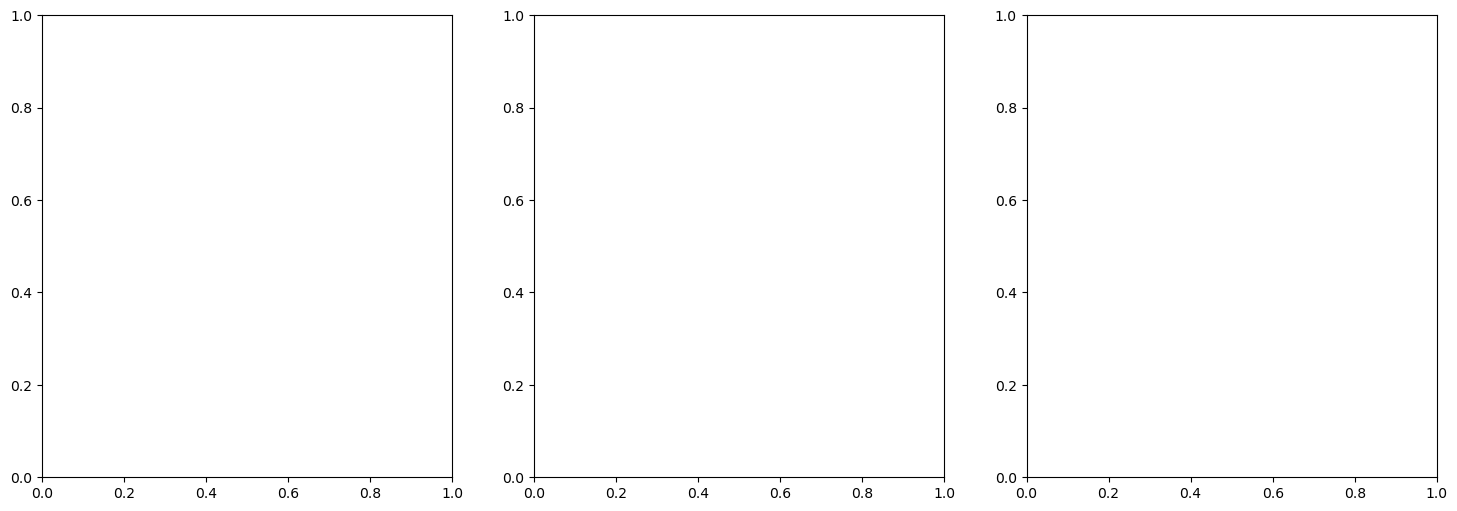

In [71]:
dataset = xr.open_dataset(file_list[5])
def plot_rhi(dataset, vel_key="radial_wind_speed", rng_key="distance"):
    fig = plt.figure(figsize=(6, 4))
    ax = plt.axes()
    #dataset = dataset.where(dataset['intensity'] > 1.01)
    az_deg = dataset['azimuth'].values
    azi = np.deg2rad(dataset['azimuth'])
    el = np.deg2rad(dataset['elevation'])
    
    rng = dataset[rng_key]
    el, rng = np.meshgrid(el, rng, indexing='ij')
    x = rng * np.cos(el)
    y = rng * np.sin(el)
    c = ax.pcolormesh(x/1e3, y, dataset[vel_key].where(
        dataset['intensity'] > 1.008), cmap='balance', vmin=-5, vmax=5)
    ax.contourf(x/1e3, y, dataset['intensity'], levels=[1.3, np.inf])
    plt.colorbar(c, ax=ax, 
                 label='Radial velocity [m/s]', location='bottom')
    ax.set_ylim([0, 500])
    ax.set_xlim([-2, 2])
    #ax.set_rlim([0, 2.0])
    #ax.set_rticks([0, 0.25, .500, 0.75, 1.000, ])
    #ax.set_thetalim([np.deg2rad(5), np.deg2rad(15)])
    #ax.set_theta_zero_location("E") 
    ax.set_ylabel('Z [m]', labelpad=40)
    ax.set_xlabel('X [km]')
    ax.set_title(str(dataset['time'].values[0]) + f' {az_deg[0]:.1f} degrees')
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()
    return fig

def plot_ppi(dataset, vel_key="radial_wind_speed", rng_key="distance"):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    #dataset = dataset.where(dataset['intensity'] > 1.008)
    
    azi = np.deg2rad(dataset['azimuth'])
    # Handle wrap around smoothly
    el = np.deg2rad(dataset['elevation'])
    rng = dataset[rng_key]
    azi, rng = np.meshgrid(azi.values, rng.values, indexing='ij')
    x = rng * np.sin(azi)
    y = rng * np.cos(azi)
    for i, elevations in enumerate([5, 10, 15]):
        mask = np.logical_and(dataset['intensity'] > 1.008,
                              dataset['elevation'] == elevations)
        
        c = ax[i].pcolormesh(x/1e3, y/1e3, dataset['radial_wind_speed'].where(
            mask), cmap='balance', vmin=-5, vmax=5)
        #ax[i].contour(x/1e3, y, dataset['intensity'], levels=[4, 5])
        plt.colorbar(c, ax=ax[i], label='Radial velocity [m/s]', location='bottom')
        ax[i].set_xlim([-2, 2])
        ax[i].set_ylim([-2, 2])
        ax[i].set_ylabel('Y [km]')
        ax[i].set_xlabel('X [km]')
        ax[i].set_title(str(dataset['time'].values[0]) + f" {elevations}")
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()
    return fig

if len(np.unique(np.round(dataset['azimuth'], 0))) < 2:
    plot_rhi(dataset, rng_key="range", vel_key="radial_velocity")
else:
    plot_ppi(dataset, rng_key="range", vel_key="radial_velocity")

In [72]:
azimuth_cal = 80.8
for i, fi in enumerate(sorted(file_list)):
    dataset = xr.open_dataset(fi)
    elevation = dataset['elevation'].values
    azimuth = dataset['azimuth'].values
    if np.abs(azimuth.max() - azimuth.min()) < 5:
        fig = plot_rhi(dataset, rng_key="distance", vel_key="radial_wind_speed")
    else:
        fig = plot_ppi(dataset)
    base, name = os.path.split(fi)
    out_path = os.path.join(base, 'quicklooks')
    out_path = os.path.join(out_path, name[:-3] + '.png')
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    dataset.close()

/var/folders/f7/j8d4tzw924s73dlkdx4d4h_c0000gp/T/ipykernel_46351/3422319497.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(x/1e3, y, dataset[vel_key].where(
/Users/rjackson/miniforge3/envs/wfip3_env/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/var/folders/f7/j8d4tzw924s73dlkdx4d4h_c0000gp/T/ipykernel_46351/3422319497.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(x/1e3, y, dataset[vel_key].where(
/Users/rjackson/miniforge3/envs/wfip3_env/lib/pyth

In [93]:
dataset['elevation'].values

array([ 5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
        5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  7. ,  9.6,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
       10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 12. , 14.6,
       15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. ,
       15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. ,
       15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. , 15. ])

In [68]:
file_list[359]

'/Users/rjackson/wfip3/data/IOP_June2025_test/User4_184_20250605_082659.nc'

In [28]:
disp = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_below('intensity', 1.01)
disp.plot_azimuth_to_rhi('radial_velocity', target_azimuth=155,  vmin=-20, vmax=0, cmap='Spectral',
                        filter_transitions=False, gatefilter=gatefilter,
                        colorbar_label='Radial Velocity [m/s]')
plt.ylim([0, 0.3])
plt.ylabel('Distance above lidar [km]')
plt.xlabel('Distance from lidar [km]')
plt.xlim([0, 4])
#plt.gca().invert_yaxis()

NameError: name 'radar' is not defined

## Gridding

In [ ]:
grid_spacing = (21, 91, 81)
grid_limits = ((0, 1000.), (-3500., 0), (-2000, 2000.))
radar.fields["radial_velocity"]["data"] = np.ma.masked_where(
    radar.fields["intensity"]["data"] <= 1.025, radar.fields["radial_velocity"]["data"])
#radar.fields["radial_velocity"]["data"] = radar.fields["radial_velocity"]["data"].filled(np.nan)
grid = pyart.map.grid_from_radars([radar], grid_shape=grid_spacing,
                                  grid_limits=grid_limits,
                                  weighting_function='Barnes2',
                                  roi_func='Barnes2',
                                  constant_roi=120.)
grid = pydda.io.read_from_pyart_grid(grid)

In [ ]:
grid

<xarray.Dataset> Size: 17MB
Dimensions:                     (time: 1, z: 21, y: 91, x: 81, nradar: 1)
Coordinates: (12/16)
  * time                        (time) object 8B 2024-08-28 20:43:43.380012
  * z                           (z) float64 168B 0.0 50.0 100.0 ... 950.0 1e+03
    lat                         (y, x) float64 59kB 41.95 41.95 ... 41.98 41.98
    lon                         (y, x) float64 59kB -87.74 -87.74 ... -87.69
  * y                           (y) float64 728B -3.5e+03 -3.461e+03 ... 0.0
  * x                           (x) float64 648B -2e+03 -1.95e+03 ... 2e+03
    ...                          ...
    origin_altitude             (nradar) float64 8B 0.0
    radar_altitude              (nradar) float64 8B 0.0
    radar_latitude              (nradar) float64 8B 41.98
    radar_longitude             (nradar) float64 8B -87.72
    radar_time                  (nradar) float64 8B 0.38
    radar_name                  (nradar) <U1 4B ''
Dimensions without coordinates: nradar
Data variables: (12/14)
    intensity                   (time, z, y, x) float64 1MB nan nan ... nan nan
    beta                        (time, z, y, x) float64 1MB nan nan ... nan nan
    spectral_width              (time, z, y, x) float64 1MB nan nan ... nan nan
    radial_velocity             (time, z, y, x) float64 1MB nan nan ... nan nan
    reflectivity                (time, z, y, x) float64 1MB nan nan ... nan nan
    ROI                         (time, z, y, x) float32 619kB 120.0 ... 120.0
    ...                          ...
    point_z                     (z, y, x) float64 1MB 0.0 0.0 ... 1e+03 1e+03
    point_altitude              (z, y, x) float64 1MB 0.0 0.0 ... 1e+03 1e+03
    point_longitude             (z, y, x) float64 1MB -87.74 -87.74 ... -87.69
    point_latitude              (z, y, x) float64 1MB 41.95 41.95 ... 41.98
    AZ                          (time, z, y, x) float64 1MB 209.7 209.1 ... 90.0
    EL                          (time, z, y, x) float64 1MB -0.01359 ... 26.56
Attributes:
    radar_name:       
    nradar:           1
    Conventions:      CF-1.7
    version:          CF-Radial-1.4
    volume_number:    0
    platform_type:    fixed
    instrument_type:  radar
    primary_axis:     axis_z
    first_grid_name:  intensity

In [ ]:
vad

<xarray.Dataset> Size: 205kB
Dimensions:                (time: 9, height: 400)
Coordinates:
  * time                   (time) datetime64[ns] 72B 2024-08-28T20:08:01.7950...
  * height                 (height) float64 3kB 12.99 38.97 ... 1.038e+04
Data variables:
    wind_speed             (time, height) float64 29kB nan 8.357 ... nan nan
    wind_direction         (time, height) float64 29kB nan 165.5 ... nan nan
    wind_speed_error       (time, height) float64 29kB nan 0.113 ... nan nan
    wind_direction_error   (time, height) float64 29kB nan 0.7746 ... nan nan
    signal_to_noise_ratio  (time, height) float64 29kB 0.004807 ... 0.002437
    residual               (time, height) float64 29kB nan 0.06919 ... nan nan
    correlation            (time, height) float64 29kB nan 0.9997 ... nan nan

In [ ]:
file_list = glob.glob('/Users/rjackson/wfip3/data/User2_184_20240828*.hpl')
for fil in file_list:
    vad = read_as_netcdf(fil, 0, 0, 0)
    vad = vad.where(vad["elevation"] < 90, drop=True)
    #dataset = read_as_netcdf(vad, 41.98053299237866, -87.71662374616044, 0.)
    #vad["signal_to_noise_ratio"] = vad["intensity"] - 1
    #vad["TKE"] = 0.5*vad["radial_velocity"].where(vad["intensity"] > 1.008).var(dim="time")
    vad = act.retrievals.compute_winds_from_ppi(vad)
    vad.to_netcdf(fil + '.nc')
    print(fil)

1
/Users/rjackson/wfip3/data/User2_184_20240828_204957.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_212304.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_194252.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_194905.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_201357.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_205441.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_213357.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_210853.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_191149.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_211337.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_212748.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_204507.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_185927.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_190535.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_202010.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_191801.hpl
1
/Users/rjackson/wfip3/data/User2_184_20240828_200743.h

In [ ]:
vads = xr.open_mfdataset('/Users/rjackson/wfip3/data/User2*.nc', concat_dim='time', combine='nested')
vads

<xarray.Dataset> Size: 6MB
Dimensions:                (time: 261, height: 400)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2024-08-28T18:54:48.8300...
  * height                 (height) float64 3kB 12.99 38.97 ... 1.038e+04
Data variables:
    wind_speed             (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>
    wind_direction         (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>
    wind_speed_error       (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>
    wind_direction_error   (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>
    signal_to_noise_ratio  (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>
    residual               (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>
    correlation            (time, height) float64 835kB dask.array<chunksize=(9, 400), meta=np.ndarray>

In [ ]:
u = -np.sin(np.deg2rad(vads["wind_direction"])) * vads["wind_speed"]
v = -np.cos(np.deg2rad(vads["wind_direction"])) * vads["wind_speed"]
vads["TKE"] = (u.rolling(time=10).var() + v.rolling(time=10).var())

In [ ]:
u.isel(height=3)[0:20]

<xarray.DataArray (time: 9)> Size: 72B
array([-1.98596946, -2.00808197, -2.07418858, -2.09630109, -2.1625809 ,
       -2.09630109, -2.16252317, -2.36107393, -2.38318644])
Coordinates:
  * time     (time) datetime64[ns] 72B 2024-08-28T20:59:39.539994 ... 2024-08...
    height   float64 8B 90.93

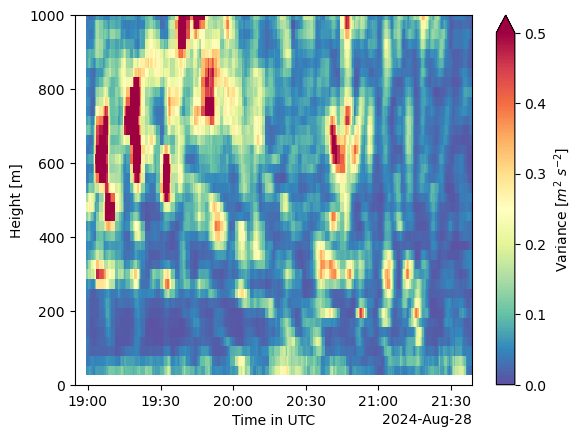

In [ ]:
vads["TKE"].T.plot(vmin=0, vmax=0.5, cmap='Spectral_r',
                                          cbar_kwargs=dict(label="Variance [$m^2\ s^{-2}$]"))
plt.ylim([0, 1000])
plt.ylabel("Height [m]")
plt.savefig('TKE_fig.png')

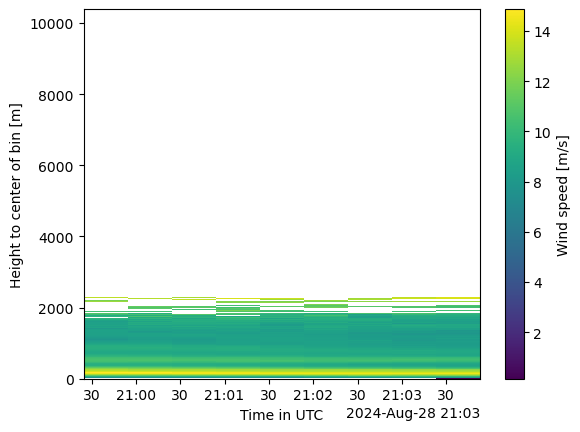

In [ ]:
vad["wind_speed"].T.plot()

In [ ]:
vad = read_as_netcdf('/Users/rjackson/wfip3/data/User2_184_20240828_204507.hpl', 0, 0, 0)
vad = vad.where(vad["elevation"] < 90, drop=True)
#dataset = read_as_netcdf(vad, 41.98053299237866, -87.71662374616044, 0.)
vad["signal_to_noise_ratio"] = vad["intensity"] - 1
vad = act.retrievals.compute_winds_from_ppi(vad)

1


In [ ]:
u = -np.sin(np.deg2rad(vad["wind_direction"])) * vad["wind_speed"]
v = -np.cos(np.deg2rad(vad["wind_direction"])) * vad["wind_speed"]
nonan = np.isfinite(u[0])
profile = pyart.core.HorizontalWindProfile(vad["height"].values[nonan], 
                                          vad["wind_speed"].values[0, nonan],
                                          vad["wind_direction"].values[0, nonan])

In [ ]:
profile.direction

array([ 14.41950719, 166.69638499, 166.6270932 , 167.93406615,
       170.894158  , 174.45418206, 178.77064474, 180.38568772,
       181.90584461, 185.21931475, 189.58884521, 192.84749005,
       194.07371217, 196.76384402, 199.59085087, 203.3147755 ,
       206.48534668, 210.21992405, 211.43793097, 213.65454107,
       217.36734503, 219.53417377, 220.13769725, 220.05541955,
       221.05694138, 220.56093   , 221.99944811, 223.05350445,
       224.06229916, 225.45734296, 224.42717199, 223.80637491,
       223.32571547, 222.49518504, 222.74464522, 222.98739159,
       222.13235606, 222.81303588, 225.41394906, 228.52742668,
       229.44859917, 231.73689976, 232.71711048, 232.82032025,
       233.49354714, 232.86356991, 235.69334724, 235.11655853,
       236.35111273, 235.53885196, 235.15937355, 235.24291959,
       234.37267389, 234.14701345, 231.83650186, 232.50177633,
       232.03650132, 231.52242584, 231.715934  , 232.15063805,
       231.07632557, 232.33154739, 231.75444911, 226.20

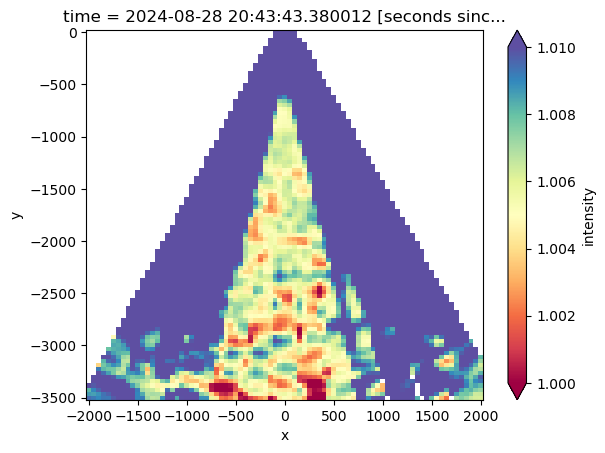

In [ ]:
grid["intensity"].sel(z=100).plot(vmin=1, vmax=1.01, cmap='Spectral')

In [ ]:
from scipy.interpolate import interp1d
grid["reflectivity"] = -99 * xr.ones_like(grid["radial_velocity"])
u_back = profile.u_wind
v_back = profile.v_wind
z_back = profile.height
u_interp = interp1d(z_back, u_back, bounds_error=False, fill_value="extrapolate")
v_interp = interp1d(z_back, v_back, bounds_error=False, fill_value="extrapolate")
u_back2 = u_interp(np.asarray(grid["z"].values))
v_back2 = v_interp(np.asarray(grid["z"].values))
grid = pydda.initialization.make_wind_field_from_profile(grid, profile)
#grid["u"] = grid["u"].fillna(0)
#grid["v"] = grid["v"].fillna(0)
#grid["w"] = grid["w"].fillna(0)

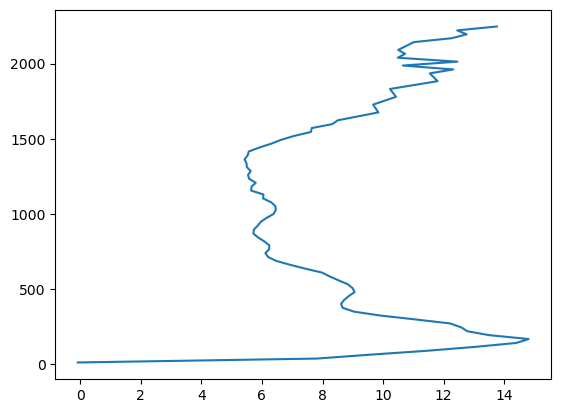

In [ ]:
plt.plot(v_back, z_back)

In [ ]:
weights_bg = np.squeeze(np.where(np.isfinite(grid["radial_velocity"].values), 0, 1))
weights_bg.shape

(21, 91, 81)

In [ ]:
grids, _ = pydda.retrieval.get_dd_wind_field([grid], u_back=u_back2, 
                                             v_back=v_back2,
                                             z_back=grid["z"].values, 
                                             vel_name="radial_velocity",
                                             weights_bg=weights_bg,
                                            Cm=16.0, Co=1e-1, Cb=1e-4, Cx=1e1, Cy=1e1, Cz=1e1,
                                            mask_outside_opt=True)

False
Interpolating sounding to radar grid
Grid levels:
[   0.   50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.
  600.  650.  700.  750.  800.  850.  900.  950. 1000.]
Starting solver 
rmsVR = 9.38370104810633
Total points: 34793
The max of w_init is 0.0
Total number of model points: 0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|6025.9284|   0.0000|   0.0000|1901.4841|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 28.467027196309086
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|1476.0966| 157.0989|   0.0687|1681.6335|   0.0000|   0.0000|   0.0000|   4.2667
The gradient of the cost functions is 32.39713973895391
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|1472.1946| 157.6734|   0.0690|1681.3924|   0.0000|   0.0000|   0.0000|   4.2717
The gradient of the cost functions is 10.784176475628001
N

In [ ]:
profile.height

array([  38.97114317,   64.95190528,   90.9326674 ,  116.91342951,
        142.89419162,  168.87495374,  194.85571585,  220.83647797,
        246.81724008,  272.79800219,  298.77876431,  324.75952642,
        350.74028853,  376.72105065,  402.70181276,  428.68257487,
        454.66333699,  480.6440991 ,  506.62486121,  532.60562333,
        558.58638544,  584.56714755,  610.54790967,  636.52867178,
        662.5094339 ,  688.49019601,  714.47095812,  740.45172024,
        766.43248235,  792.41324446,  818.39400658,  844.37476869,
        870.3555308 ,  896.33629292,  922.31705503,  948.29781714,
        974.27857926, 1000.25934137, 1026.24010348, 1052.2208656 ,
       1078.20162771, 1104.18238983, 1130.16315194, 1156.14391405,
       1182.12467617, 1208.10543828, 1234.08620039, 1260.06696251,
       1286.04772462, 1312.02848673, 1338.00924885, 1363.99001096,
       1389.97077307, 1415.95153519, 1441.9322973 , 1467.91305941,
       1493.89382153, 1519.87458364, 1545.85534576, 1571.83610

Text(0.5, 1.0, 'Winds at 100 m')

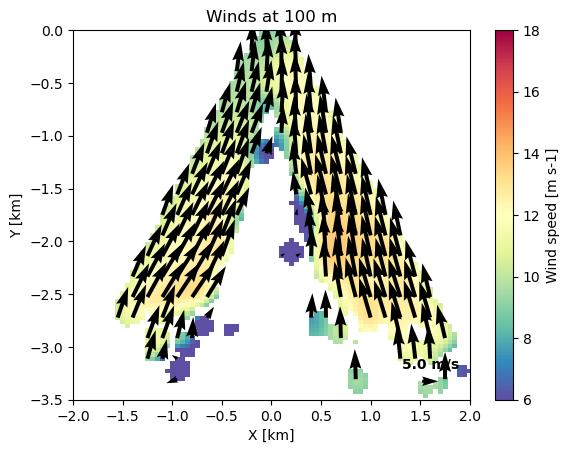

In [ ]:
grids[0]["wind_speed"] = np.sqrt(grids[0]["u"]**2 + grids[0]["v"]**2)
grids[0]["wind_speed"].attrs["long_name"] = "Wind speed"
grids[0]["wind_speed"].attrs["units"] = "m s-1"
pydda.vis.plot_horiz_xsection_quiver(grids, level=2, background_field="wind_speed",
                                   vmin=6, vmax=18, cmap='Spectral_r',
                                   quiver_spacing_x_km=0.2, quiver_spacing_y_km=0.2)
plt.title("Winds at 100 m")

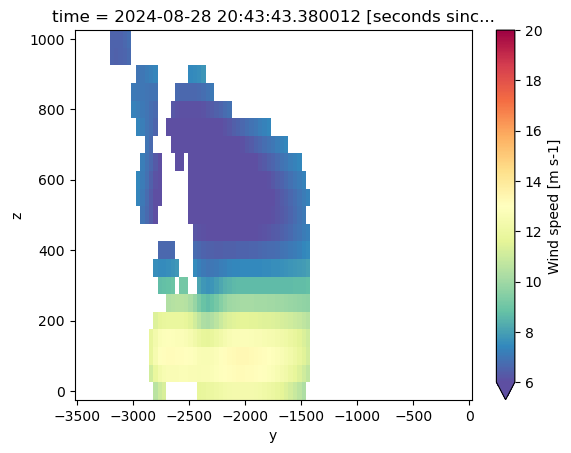

In [ ]:
grids[0]["wind_speed"].sel(
    x=1000., method='nearest', ).plot(vmin=6, vmax=20, cmap='Spectral_r')

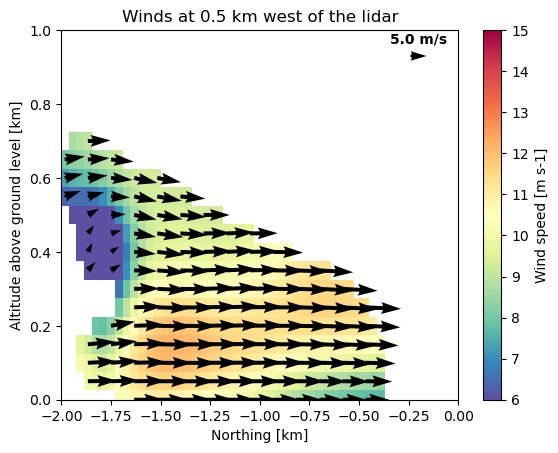

In [ ]:
pydda.vis.plot_yz_xsection_quiver(grids, level=33, background_field="wind_speed",
                                  vmin=6, vmax=15, cmap='Spectral_r',
                                   quiver_spacing_y_km=0.2, quiver_spacing_z_km=0.05)
plt.xlim([-2, 0])
plt.xlabel("Northing [km]")
plt.ylabel("Altitude above ground level [km]")
plt.title("Winds at 0.5 km west of the lidar")
plt.savefig("3dvar_winds_Aug28.png", bbox_inches='tight')
#plt.title("Winds at 0 km east of lidar")

In [ ]:
grids[0]['vert_shear'] = (['time', 'z', 'y', 'x'], np.gradient(grids[0]["wind_speed"], .05, axis=1))
grids[0]['vert_shear'].attrs["long_name"] = "Vertical wind shear"
grids[0]['vert_shear'].attrs["units"] = "m s-1 km-1"
del grids[0]["time"].attrs["units"]
grids[0].to_netcdf('%s.3dvar.nc' % fname)                               

In [ ]:
winds = xr.open_mfdataset('/Users/rjackson/wfip3/data/User1_184_20240828_20*.3dvar.nc')
winds

<xarray.Dataset> Size: 69MB
Dimensions:                     (time: 3, z: 21, y: 91, x: 81, nradar: 1)
Coordinates: (12/16)
  * time                        (time) datetime64[ns] 24B 2024-08-28T20:31:14...
  * z                           (z) float64 168B 0.0 50.0 100.0 ... 950.0 1e+03
    lat                         (y, x) float64 59kB dask.array<chunksize=(91, 81), meta=np.ndarray>
    lon                         (y, x) float64 59kB dask.array<chunksize=(91, 81), meta=np.ndarray>
  * y                           (y) float64 728B -3.5e+03 -3.461e+03 ... 0.0
  * x                           (x) float64 648B -2e+03 -1.95e+03 ... 2e+03
    ...                          ...
    origin_altitude             (nradar) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    radar_altitude              (nradar) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    radar_latitude              (nradar) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    radar_longitude             (nradar) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    radar_time                  (time, nradar) float64 24B dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_name                  (nradar) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: nradar
Data variables: (12/19)
    intensity                   (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    beta                        (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    spectral_width              (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    radial_velocity             (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    reflectivity                (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    ROI                         (time, z, y, x) float32 2MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    ...                          ...
    EL                          (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    u                           (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    v                           (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    w                           (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    wind_speed                  (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
    vert_shear                  (time, z, y, x) float64 4MB dask.array<chunksize=(1, 21, 91, 81), meta=np.ndarray>
Attributes:
    radar_name:       
    nradar:           1
    Conventions:      CF-1.7
    version:          CF-Radial-1.4
    volume_number:    0
    platform_type:    fixed
    instrument_type:  radar
    primary_axis:     axis_z
    first_grid_name:  intensity

In [ ]:
u_variance = winds["u"].where(winds["intensity"] > 1.025).rolling(x=3, y=3).var()
v_variance = winds["v"].where(winds["intensity"] > 1.025).rolling(x=3, y=3).var()
TKE = u_variance + v_variance

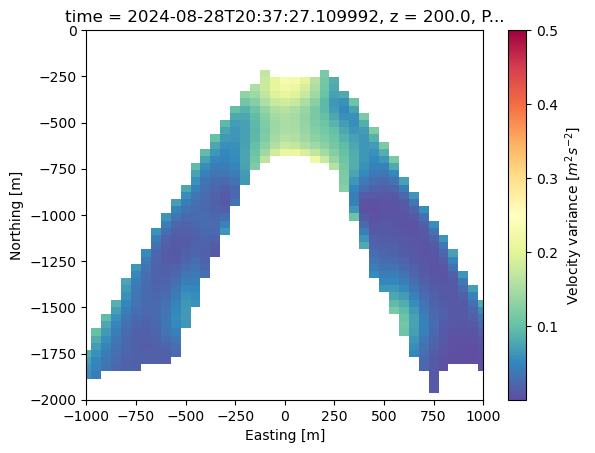

In [ ]:
TKE.isel(time=1).sel(z=200., method='nearest').plot(vmax=0.5, cmap='Spectral_r', cbar_kwargs=dict(label="Velocity variance [$m^{2} s^{-2}$]"))
plt.xlim([-1000, 1000])
plt.ylim([-2000, 0])
#plt.title("Height = 200 m")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.savefig('TKE_spatial_fig.png')

In [ ]:
TKE.T.isel(x=30).sel(y=-1000., method='nearest').mean(dim='time').plot(y='z', label='1000 m')
TKE.T.isel(x=30).sel(y=-1500., method='nearest').mean(dim='time').plot(y='z', label='1500 m')
plt.legend()

ValueError: Dimensions {'x'} do not exist. Expected one or more of ('y', 'z')

(-2000.0, 0.0)

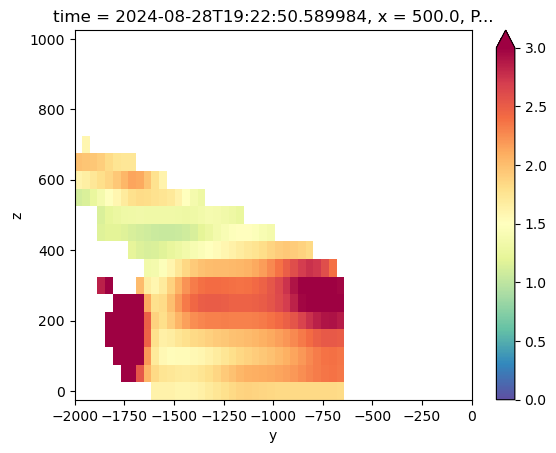

In [ ]:
TKE.isel(time=3).sel(x=500., method='nearest').plot(cmap='Spectral_r', vmin=0, vmax=3)
plt.xlim([-2000, 0])

(-2000.0, 0.0)

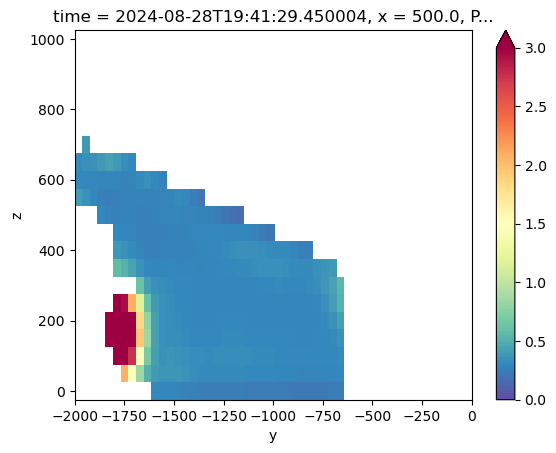

In [ ]:
TKE.isel(time=5).sel(x=500., method='nearest').plot(cmap='Spectral_r', vmin=0, vmax=3)
plt.xlim([-2000, 0])

Text(0.5, 1.0, 'Shear at 500 m west of lidar')

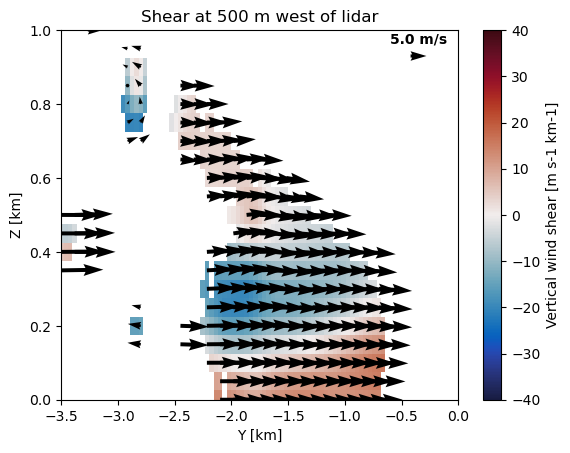

In [ ]:
pydda.vis.plot_yz_xsection_quiver(grids, level=30, background_field="vert_shear",
                                  vmin=-40, vmax=40, cmap='balance',
                                   quiver_spacing_y_km=0.2, quiver_spacing_z_km=0.05)
plt.title("Shear at 500 m west of lidar")

In [ ]:
import sage_data_client
import requests

df = sage_data_client.query(
    start="-1h",
    filter={
        "plugin": "10.31.81.1:5000/local/plugin-lidarspectra",
        "vsn": "W0BE"
    }
)
file_list = list(df.value.values)
file_names = list(df['meta.filename'].values)
df

,timestamp,name,value,meta.filename,meta.host,meta.job,meta.node,meta.plugin,meta.task,meta.vsn,meta.zone
0,2024-06-16 23:55:44.015013888+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,nant.lidarspectra.z02.c1.20240616.230010.nc,000048b02dd3c637.ws-nxcore,Pluginctl,000048b02dd3c637,10.31.81.1:5000/local/plugin-lidarspectra,lidarspectra,W0BE,core


In [ ]:
username = 'rjackson'
password = '49GOS28FFE6I8REWMMD6'
    
def readtofile(uurl, ff, username, password):
    r = requests.get(uurl, auth=(username,password))
    print(uurl)
    if r.status_code == 200:
        print('Downloading %s' % uurl[-18:])
        with open(ff, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    
    return True
    
temp_file_list = []
for i, f in enumerate(file_list):
    name = file_names[i]
    out_name = '/Users/rjackson/wfip3/data/%s' % name
    if not os.path.exists(out_name):
        readtofile(f, out_name, username, password)
    if not out_name in temp_file_list:
        temp_file_list.append(out_name)

https://storage.sagecontinuum.org/api/v1/data/Pluginctl/sage-lidarspectra-latest/000048b02dd3c637/1718582144015013888-nant.lidarspectra.z02.c1.20240616.230010.nc


In [ ]:

ds = xr.open_dataset(
    '/Users/rjackson/wfip3/data/nant.lidarspectra.z02.c1.20240616.031716.nc')
ds['range'] = ('range', 60 * np.arange(ds.sizes['range']))
all_nan = ds['doppler_velocity'].max(dim='range') > -30

(0.0, 3000.0)

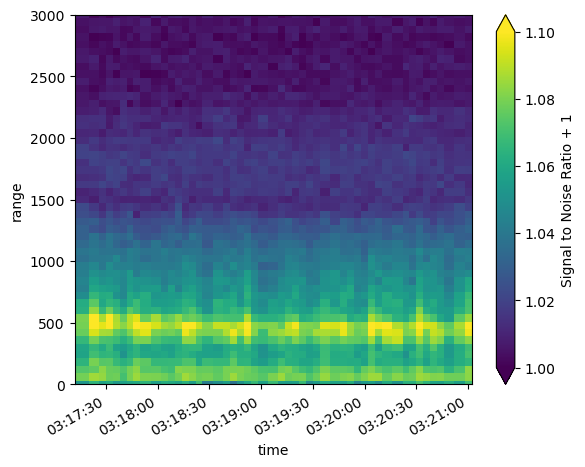

In [ ]:
ds['intensity'].where(all_nan, drop=True).T.plot(vmin=1,vmax=1.1)
plt.ylim([0, 3000])

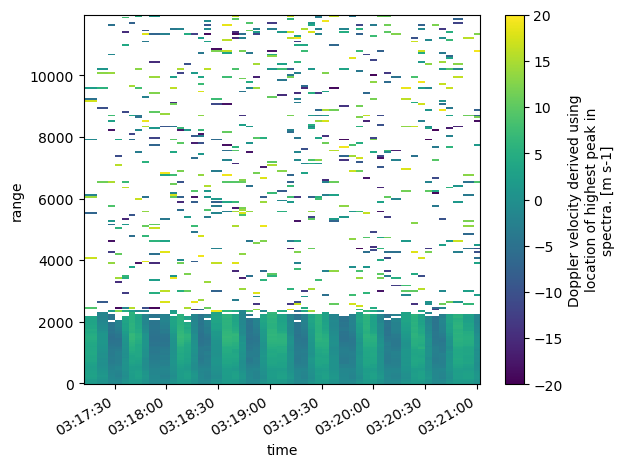

In [ ]:
ds['doppler_velocity'].where(all_nan, drop=True).T.plot(vmin=-20, vmax=20)

In [ ]:
ds['spectrum_index'] = ds['spectrum_index'].where(ds['spectrum_index'] > 0)

Text(0.5, 0, 'Doppler velocity')

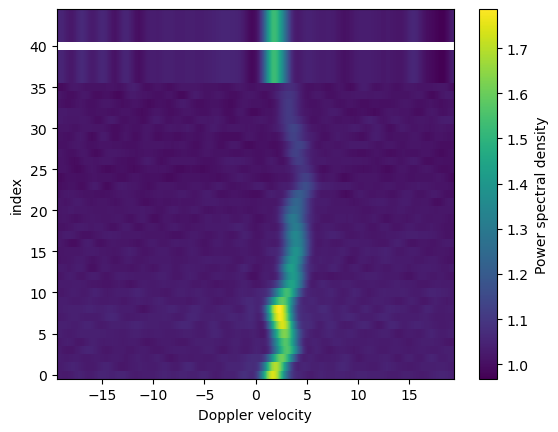

In [ ]:
inds = ds['spectrum_index'].isel(time=0).dropna(dim='range').values.astype(int)
spec = ds['power_spectral_density'].isel(index=inds)
spec['sample'] = ('sample', ds['vel_bins'].values)
spec.plot(x='sample')
plt.xlabel('Doppler velocity')

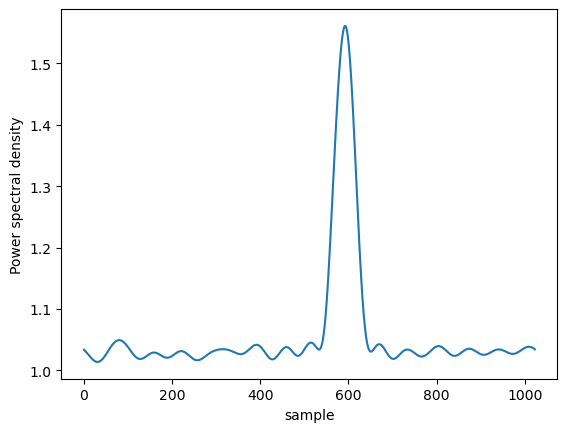

In [ ]:
spec = ds['power_spectral_density'][4].plot()

In [ ]:
inds[5]

51